In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import torch
# from torch import vmap
from functorch import vmap, grad

from models import FNN2d, FNN2d_AD
from train_utils import Adam
# from train_utils.datasets import BurgersLoader'
# from train_utils.train_2d import train_2d_burger
# from train_utils.eval_2d import eval_burgers

from solver.BurgersEq import BurgersEq1D
import traceback

import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import imageio



from tqdm import tqdm
from train_utils.utils import get_grid, save_checkpoint, torch2dgrid, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader1D
# from utils import torch2dgrid
from solver.my_random_fields import GRF_Mattern

from importlib import reload

try:
    import wandb
except ImportError:
    wandb = None


def FDM_Burgers(u, D=1, nu=0.01):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    u2 = u**2
    dt = D / (nt-1)
    dx = D / (nx)

    u_h = torch.fft.fft(u, dim=2)
    u2_h = torch.fft.fft(u2, dim=2)
    # Wavenumbers in y-direction
    k_max = nx//2
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=u.device),
                     torch.arange(start=-k_max, end=0, step=1, device=u.device)), 0).reshape(1,1,nx)
    ux_h = 2j *np.pi*k_x*u_h
    u2x_h = 2j *np.pi*k_x*u2_h
    uxx_h = 2j *np.pi*k_x*ux_h
    ux = torch.fft.irfft(ux_h[:, :, :k_max+1], dim=2, n=nx)
    u2x = torch.fft.irfft(u2x_h[:, :, :k_max+1], dim=2, n=nx)
    uxx = torch.fft.irfft(uxx_h[:, :, :k_max+1], dim=2, n=nx)
    ut = (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)
    Du = ut + (0.5*u2x - nu*uxx)[:,1:-1,:]
#     Du = ut + (u*ux - nu*uxx)[:,1:-1,:]
    return Du


def PINO_loss_Burgers(u, u0, nu=0.01):
    batchsize = u.size(0)
    nt = u.size(1)
    nx = u.size(2)

    u = u.reshape(batchsize, nt, nx)
    # lploss = LpLoss(size_average=True)

    index_t = torch.zeros(nx,).long()
    index_x = torch.tensor(range(nx)).long()
    boundary_u = u[:, index_t, index_x]
    loss_u = F.mse_loss(boundary_u, u0)

    Du = FDM_Burgers(u, nu=nu)[:, :, :]
    f = torch.zeros(Du.shape, device=u.device)
    loss_f = F.mse_loss(Du, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_u, loss_f


C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\947167252.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
loss_1=[]
def train_Burgers(model,
                  train_loader,
                  optimizer, 
                  scheduler,
                  config,
                  rank=0,
                  log=False,
                  project='PINO-2d-default',
                  group='default',
                  tags=['default'],
                  use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    nu = config['data']['nu']
    ckpt_freq = config['train']['ckpt_freq']

    model.train()
    myloss = LpLoss(size_average=True)
    
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_u, loss_f = PINO_loss_Burgers(out, x[:, 0, :, 0], nu=nu)
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        loss_1.append([e,train_loss])
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [8]:
loss_2=[]
def train_Burgers_padding(model,
                          train_loader,
                          optimizer, 
                          scheduler,
                          config,
                          padding=0,
                          rank=0,
                          log=False,
                          project='PINO-2d-default',
                          group='default',
                          tags=['default'],
                          use_tqdm=True):
    
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    nu = config['data']['nu']
    ckpt_freq = config['train']['ckpt_freq']
    model.train()
    myloss = LpLoss(size_average=True)
    
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        data_l2 = 0.0
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
#             print(y.shape)
            x_in = F.pad(x, (0, 0, 0, 0, 0, padding), "constant", 0)
#             display(x.shape, x_in.shape)
            batch_size, T, S = old_shape = y.shape
            new_shape = (batch_size, T + padding, S)
            out = model(x_in).reshape(batch_size, T + padding, S)
            out = out[..., :-padding, :]
            
#             out = model(x).reshape(y.shape)
            u0 = x[:, 0, :, 0]
    
            data_loss = myloss(out.view(batch_size, T, S), y.view(batch_size, T, S))
            
            loss_u, loss_f = PINO_loss_Burgers(out.view(batch_size, T, S), u0, nu=nu)
            total_loss = loss_u * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_loss += total_loss.item()
            
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_loss /= len(train_loader)
        loss_2.append([e,train_loss])
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [9]:
def eval_Burgers(model,
                 dataloader,
                 config,
                 device,
                 use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    nu = config['data']['nu']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_Burgers(out, x[:, 0, :, 0], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')


def eval_Burgers_padding(model,
                         dataloader,
                         config,
                         padding=0,
                         device=None,
                         use_tqdm=True):
    model.eval()
    myloss = LpLoss(size_average=True)
    nu = config['data']['nu']
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            x_in = F.pad(x, (0, 0, 0, 0, 0, padding), "constant", 0)
            batch_size, T, S = old_shape = y.shape
            new_shape = (batch_size, T + padding, S)
            out = model(x_in).reshape(batch_size, T + padding, S)
            out = out[..., :-padding, :]
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)

            loss_u, f_loss = PINO_loss_Burgers(out, x[:, 0, :, 0], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')
            
            
        

In [10]:
config_file = 'configs/custom/burgers1d-sarry01.yaml'
config = load_config(config_file)
display(config)

{'data': {'name': 'Burgers1d-sarry-01',
  'total_num': 50,
  'n_train': 45,
  'n_test': 5,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 1500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 5.0,
  'save_dir': 'Burgers',
  'save_name': 'Burgers1d-sarry-01.pt',
  'ckpt': 'checkpoints/Burgers/Burgers1d-sarry-01.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers1d-sarry-01'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Burgers/Burgers1d-sarry-01.pt'}}

In [11]:
Nsamples = config['data']['total_num']
N = config['data']['nx']
Nt0 = config['data']['nt']
nu = config['data']['nu']
sub_x = config['data']['sub']
sub_t = config['data']['sub_t']
Nx = N // sub_x
Nt = Nt0 // sub_t + 1
dim = 1
l = 0.1
L = 1.0
sigma = 0.5 #2.0
Nu = None # 2.0
dt = 1.0e-4
tend = 1.0
save_int = int(tend/dt/Nt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
display(save_int)

99

In [13]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples) # 高斯随机采样点,表示初始u
U0[45]=torch.sin(torch.pi*torch.linspace(0,1,128))
U0[0]=torch.sin(torch.pi*torch.linspace(0,1,128))
# U0=torch.randn(100,128).to(device)

In [14]:
grf.size

(128,)

In [15]:
U0.shape

torch.Size([50, 128])

In [16]:
U0

tensor([[ 0.0000e+00,  2.4734e-02,  4.9454e-02,  ...,  4.9453e-02,
          2.4734e-02, -8.7423e-08],
        [-9.2349e-02, -1.0416e-01, -1.1671e-01,  ..., -6.2506e-02,
         -7.1473e-02, -8.1428e-02],
        [ 2.7952e-01,  2.3381e-01,  1.8416e-01,  ...,  3.7929e-01,
          3.5342e-01,  3.1981e-01],
        ...,
        [ 1.2582e-01,  1.0501e-01,  8.2066e-02,  ...,  1.7384e-01,
          1.6036e-01,  1.4432e-01],
        [-3.8669e-02, -5.6523e-02, -7.2091e-02,  ...,  1.7525e-02,
         -4.6735e-04, -1.9597e-02],
        [ 3.0741e-01,  3.3189e-01,  3.5309e-01,  ...,  2.1767e-01,
          2.4989e-01,  2.7995e-01]], device='cuda:0')

In [17]:
burgers_eq = BurgersEq1D(Nx=Nx, nu=nu, dt=dt, device=device)
save_interval = int(1e-2/dt)  # 保存多少份，这里是1s，每隔0.01s保存一份，总共是100份
U = vmap(burgers_eq.burgers_driver, in_dims=(0, None))(U0, save_interval)  #高效求解burgers方程

D:\software\anaconda\envs\pytorch\lib\site-packages\torch\_functorch\deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [18]:
torch.save(U,"Burgers1D/precise/burgers_1d.pth")

In [19]:
U = torch.load("Burgers1D/precise/burgers_1d.pth")

In [20]:
U

tensor([[[ 0.0000e+00,  2.4734e-02,  4.9454e-02,  ...,  4.9453e-02,
           2.4734e-02, -8.7423e-08],
         [ 2.4866e-02,  3.4463e-02,  5.1543e-02,  ...,  5.4603e-02,
           3.6128e-02,  2.5379e-02],
         [ 3.8909e-02,  4.5182e-02,  5.7721e-02,  ...,  6.3841e-02,
           4.8649e-02,  4.0022e-02],
         ...,
         [ 7.3936e-01,  7.4452e-01,  7.4966e-01,  ...,  7.2373e-01,
           7.2896e-01,  7.3417e-01],
         [ 7.3445e-01,  7.3960e-01,  7.4472e-01,  ...,  7.1887e-01,
           7.2408e-01,  7.2928e-01],
         [ 7.2958e-01,  7.3472e-01,  7.3983e-01,  ...,  7.1406e-01,
           7.1925e-01,  7.2443e-01]],

        [[-9.2349e-02, -1.0416e-01, -1.1671e-01,  ..., -6.2506e-02,
          -7.1473e-02, -8.1428e-02],
         [-9.5117e-02, -1.0696e-01, -1.1944e-01,  ..., -6.4770e-02,
          -7.3954e-02, -8.4083e-02],
         [-9.7794e-02, -1.0962e-01, -1.2199e-01,  ..., -6.7024e-02,
          -7.6406e-02, -8.6682e-02],
         ...,
         [-6.5475e-02, -6

In [21]:
a = U0.cpu().float()  # 高斯随机采样点,表示初始u
u = U.cpu().float()   # u是计算出来的数值解
display(a.shape,u.shape)  #100表示总共生成了100组测试数据，101表示总共的时间步，128表示横坐标一共有多少个

torch.Size([50, 128])

torch.Size([50, 101, 128])

In [22]:
display(config)

{'data': {'name': 'Burgers1d-sarry-01',
  'total_num': 50,
  'n_train': 45,
  'n_test': 5,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [16, 24, 24, 32, 32],
  'modes1': [15, 12, 9, 9],
  'modes2': [15, 12, 9, 9],
  'fc_dim': 128,
  'activation': 'gelu'},
 'train': {'batchsize': 20,
  'epochs': 1500,
  'milestones': [100, 200, 300, 400, 500],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 1.0,
  'xy_loss': 5.0,
  'save_dir': 'Burgers',
  'save_name': 'Burgers1d-sarry-01.pt',
  'ckpt': 'checkpoints/Burgers/Burgers1d-sarry-01.pt',
  'ckpt_freq': 100},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers1d-sarry-01'},
 'test': {'batchsize': 1, 'ckpt': 'checkpoints/Burgers/Burgers1d-sarry-01.pt'}}

In [23]:
dataset = DataLoader1D(a, u, config['data']['nx'], config['data']['nt'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

In [24]:
model = FNN2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              activation=config['model']['activation']
             ).to(device)

In [25]:
log = False

optimizer = Adam(model.parameters(), betas=(0.9, 0.999),lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

In [26]:
load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)

Weights loaded from checkpoints/Burgers/Burgers1d-sarry-01.pt


In [27]:
train_Burgers(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 2, train loss: 0.23816 train f error: 0.00985; data l2 error: 0.04539:   0%|          | 3/1500 [00:01<12:53,  1.93it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_0.pt


Epoch 102, train loss: 0.02843 train f error: 0.00057; data l2 error: 0.00557:   7%|▋         | 103/1500 [00:09<01:47, 12.97it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_100.pt


Epoch 202, train loss: 0.01300 train f error: 0.00045; data l2 error: 0.00251:  14%|█▎        | 203/1500 [00:17<01:41, 12.82it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_200.pt


Epoch 302, train loss: 0.00850 train f error: 0.00042; data l2 error: 0.00161:  20%|██        | 303/1500 [00:24<01:37, 12.29it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_300.pt


Epoch 402, train loss: 0.00736 train f error: 0.00038; data l2 error: 0.00139:  27%|██▋       | 403/1500 [00:32<01:25, 12.84it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_400.pt


Epoch 502, train loss: 0.00643 train f error: 0.00038; data l2 error: 0.00121:  34%|███▎      | 503/1500 [00:40<01:23, 11.90it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_500.pt


Epoch 602, train loss: 0.00652 train f error: 0.00037; data l2 error: 0.00123:  40%|████      | 603/1500 [00:49<01:14, 11.97it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_600.pt


Epoch 702, train loss: 0.00580 train f error: 0.00035; data l2 error: 0.00109:  47%|████▋     | 703/1500 [00:57<01:04, 12.39it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_700.pt


Epoch 802, train loss: 0.00602 train f error: 0.00035; data l2 error: 0.00113:  54%|█████▎    | 803/1500 [01:05<00:56, 12.34it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_800.pt


Epoch 902, train loss: 0.00575 train f error: 0.00034; data l2 error: 0.00108:  60%|██████    | 903/1500 [01:13<00:48, 12.19it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_900.pt


Epoch 1002, train loss: 0.00544 train f error: 0.00034; data l2 error: 0.00102:  67%|██████▋   | 1003/1500 [01:21<00:41, 11.97it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1000.pt


Epoch 1102, train loss: 0.00603 train f error: 0.00033; data l2 error: 0.00114:  73%|███████▎  | 1101/1500 [01:30<00:33, 11.94it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1100.pt


Epoch 1202, train loss: 0.00538 train f error: 0.00032; data l2 error: 0.00101:  80%|████████  | 1203/1500 [01:37<00:23, 12.54it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1200.pt


Epoch 1302, train loss: 0.00582 train f error: 0.00031; data l2 error: 0.00110:  87%|████████▋ | 1303/1500 [01:45<00:15, 12.53it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1300.pt


Epoch 1402, train loss: 0.00490 train f error: 0.00031; data l2 error: 0.00092:  94%|█████████▎| 1403/1500 [01:53<00:07, 12.44it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1400.pt


Epoch 1499, train loss: 0.00614 train f error: 0.00102; data l2 error: 0.00102: 100%|██████████| 1500/1500 [02:01<00:00, 12.33it/s]


Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01.pt
Done!


In [28]:
train_Burgers_padding(model,
              train_loader,
              optimizer,
              scheduler,
              config,
              padding=5,
              rank=0,
              log=log,
              project=config['log']['project'],
              group=config['log']['group'])

Epoch 2, train loss: 0.11620 train f error: 0.00360; data l2 error: 0.02238:   0%|          | 3/1500 [00:00<04:42,  5.30it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_0.pt


Epoch 102, train loss: 0.00769 train f error: 0.00039; data l2 error: 0.00146:   7%|▋         | 101/1500 [00:09<02:06, 11.09it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_100.pt


Epoch 202, train loss: 0.00595 train f error: 0.00028; data l2 error: 0.00113:  14%|█▎        | 203/1500 [00:18<02:00, 10.73it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_200.pt


Epoch 302, train loss: 0.00508 train f error: 0.00023; data l2 error: 0.00097:  20%|██        | 301/1500 [00:27<01:50, 10.81it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_300.pt


Epoch 402, train loss: 0.00571 train f error: 0.00071; data l2 error: 0.00100:  27%|██▋       | 403/1500 [00:36<01:40, 10.94it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_400.pt


Epoch 502, train loss: 0.00460 train f error: 0.00020; data l2 error: 0.00088:  33%|███▎      | 501/1500 [00:45<01:29, 11.20it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_500.pt


Epoch 602, train loss: 0.00442 train f error: 0.00019; data l2 error: 0.00085:  40%|████      | 603/1500 [00:55<01:21, 10.98it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_600.pt


Epoch 701, train loss: 0.00441 train f error: 0.00018; data l2 error: 0.00085:  47%|████▋     | 701/1500 [01:04<01:13, 10.93it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_700.pt


Epoch 802, train loss: 0.00470 train f error: 0.00017; data l2 error: 0.00091:  54%|█████▎    | 803/1500 [01:13<01:03, 11.01it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_800.pt


Epoch 902, train loss: 0.00411 train f error: 0.00017; data l2 error: 0.00079:  60%|██████    | 903/1500 [01:22<00:53, 11.16it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_900.pt


Epoch 1002, train loss: 0.00416 train f error: 0.00051; data l2 error: 0.00073:  67%|██████▋   | 1001/1500 [01:31<00:44, 11.17it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1000.pt


Epoch 1102, train loss: 0.00417 train f error: 0.00015; data l2 error: 0.00080:  73%|███████▎  | 1101/1500 [01:40<00:35, 11.17it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1100.pt


Epoch 1202, train loss: 0.00386 train f error: 0.00015; data l2 error: 0.00074:  80%|████████  | 1203/1500 [01:49<00:26, 11.30it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1200.pt


Epoch 1302, train loss: 0.00359 train f error: 0.00015; data l2 error: 0.00069:  87%|████████▋ | 1303/1500 [01:57<00:17, 11.45it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1300.pt


Epoch 1402, train loss: 0.00356 train f error: 0.00014; data l2 error: 0.00068:  94%|█████████▎| 1403/1500 [02:06<00:08, 11.39it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01_1400.pt


Epoch 1499, train loss: 0.00323 train f error: 0.00013; data l2 error: 0.00062: 100%|██████████| 1500/1500 [02:15<00:00, 11.10it/s]

Checkpoint is saved at checkpoints/Burgers/Burgers1d-sarry-01.pt
Done!


In [29]:
eval_Burgers(model, test_loader, config, device)

100%|██████████| 5/5 [00:00<00:00, 12.54it/s]

==Averaged relative L2 error mean: 0.05284850150346756, std error: 0.014200363886054604==
==Averaged equation error mean: 0.047230330668389796, std error: 0.04526200147705188==


In [30]:
eval_Burgers_padding(model, test_loader, config=config, padding=5, device=device)

100%|██████████| 5/5 [00:00<00:00, 63.34it/s]

==Averaged relative L2 error mean: 0.0015836142702028155, std error: 0.0002143657006879101==
==Averaged equation error mean: 0.0012155063970567426, std error: 0.0011881432920561384==


In [31]:
Nx = config['data']['nx']
Nt = config['data']['nt'] + 1
N = config['data']['n_test']
model.eval()
test_x = np.zeros((N,Nt,Nx,3))
preds_y = np.zeros((N,Nt,Nx))
test_y = np.zeros((N,Nt,Nx))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)


In [32]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        print(pred_y.shape)
        print(data_x.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        preds_y[i] = pred_y.cpu().numpy()

torch.Size([1, 101, 128])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128])
torch.Size([1, 101, 128, 3])


In [33]:
use_train_data = False
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
# Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
Ntrain = config['data']['n_train']
loader = test_loader
if use_train_data:
    Ntest = Ntrain
    loader = train_loader
# in_dim = config['model']['in_dim']
# out_dim = config['model']['out_dim']


model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nt,Nx,3))
preds_y = np.zeros((Ntest,Nt,Nx))
test_y = np.zeros((Ntest,Nt,Nx))


with torch.no_grad():
    for i, data in enumerate(loader):
#     for i, data in enumerate(train_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nt + padding, Nx)
#         out = out[..., :-padding, :]
#         pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding, out_dim)
        pred_y = pred_y_pad[..., :-padding, :].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
#         test_y0[i] = data_x[..., 0, -out_dim:].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

In [34]:
len(loader)

5

In [35]:
key = 1
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]

In [36]:
x

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

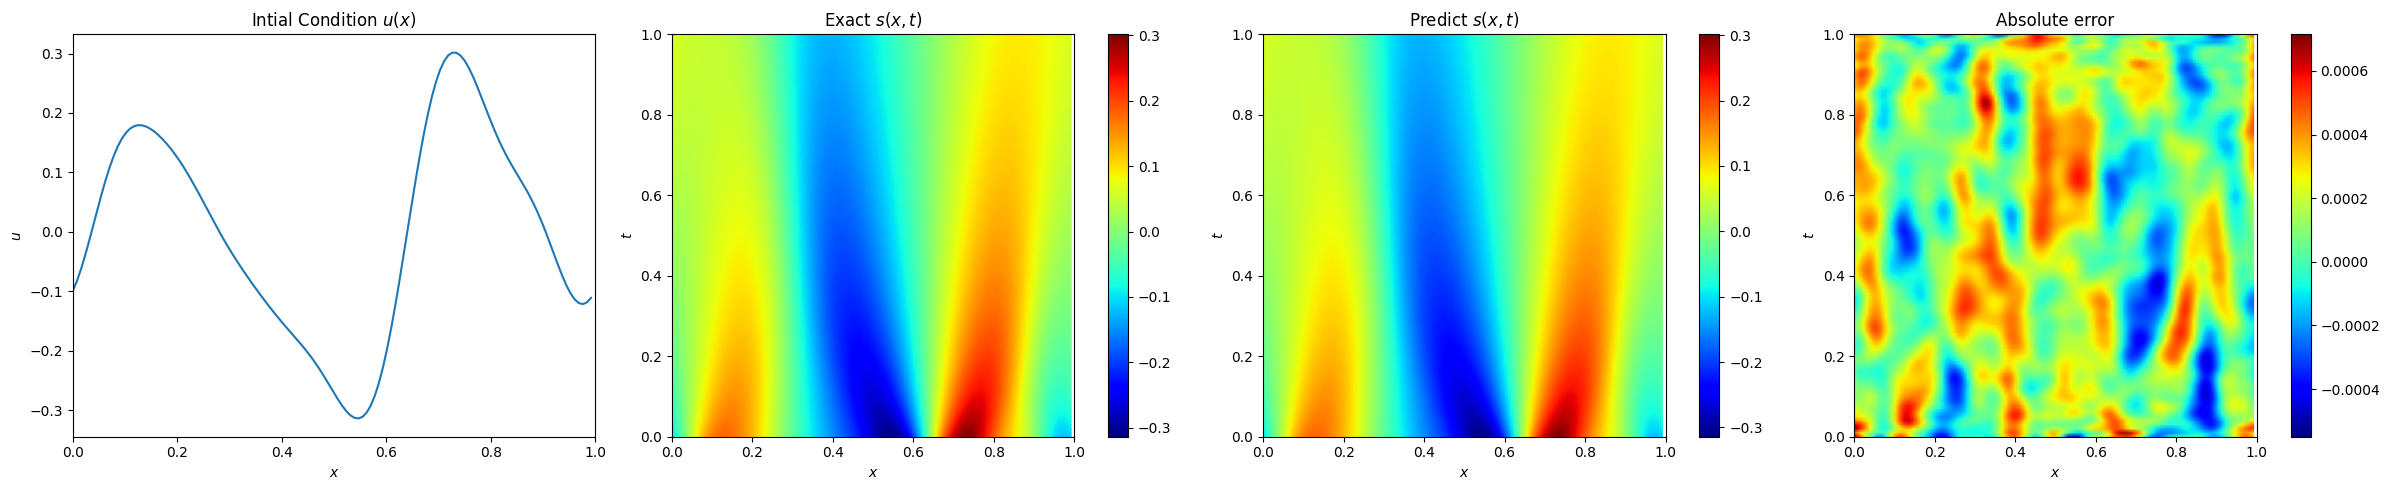

In [37]:
%matplotlib inline
fig = plt.figure(figsize=(24,5))
plt.subplot(1,4,1)

plt.plot(x, u0)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Intial Condition $u(x)$')
plt.xlim([0,1])
plt.tight_layout()

plt.subplot(1,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Exact $s(x,t)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title(f'Predict $s(x,t)$')
plt.axis('square')

plt.tight_layout()

plt.subplot(1,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.axis('square')

plt.show()

In [38]:
def save_data(data_path, test_x, test_y, preds_y):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    return test_x, test_y, preds_y

In [39]:
data_dir = 'data/Burgers1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [40]:
save_data(data_path, test_x, test_y, preds_y)

In [41]:
test_x, test_y, preds_y = load_data(data_path)

In [42]:
test_x.shape  # 30表示总共有30个例子，101表示没0.01s一个画面，128表示横坐标一共有128个

(5, 101, 128, 3)

In [43]:
def plot_predictions(key, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    pred = preds_y[key]
    true = test_y[key]


    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]

    # Plot
    fig = plt.figure(figsize=(23,5))
    plt.subplot(1,4,1)

    plt.plot(x, u0)
    plt.xlabel('$x$')
    plt.ylabel('$u$')
    plt.title('Intial Condition $u(x)$')
    plt.xlim([0,1])
    plt.tight_layout()

    plt.subplot(1,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, T, true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Exact $u(x,t)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(1,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, T, pred, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title(f'Predict $u(x,t)$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(1,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, T, pred - true, cmap='jet', shading='gouraud')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Absolute Error')
    plt.tight_layout()
    plt.axis('square')

    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


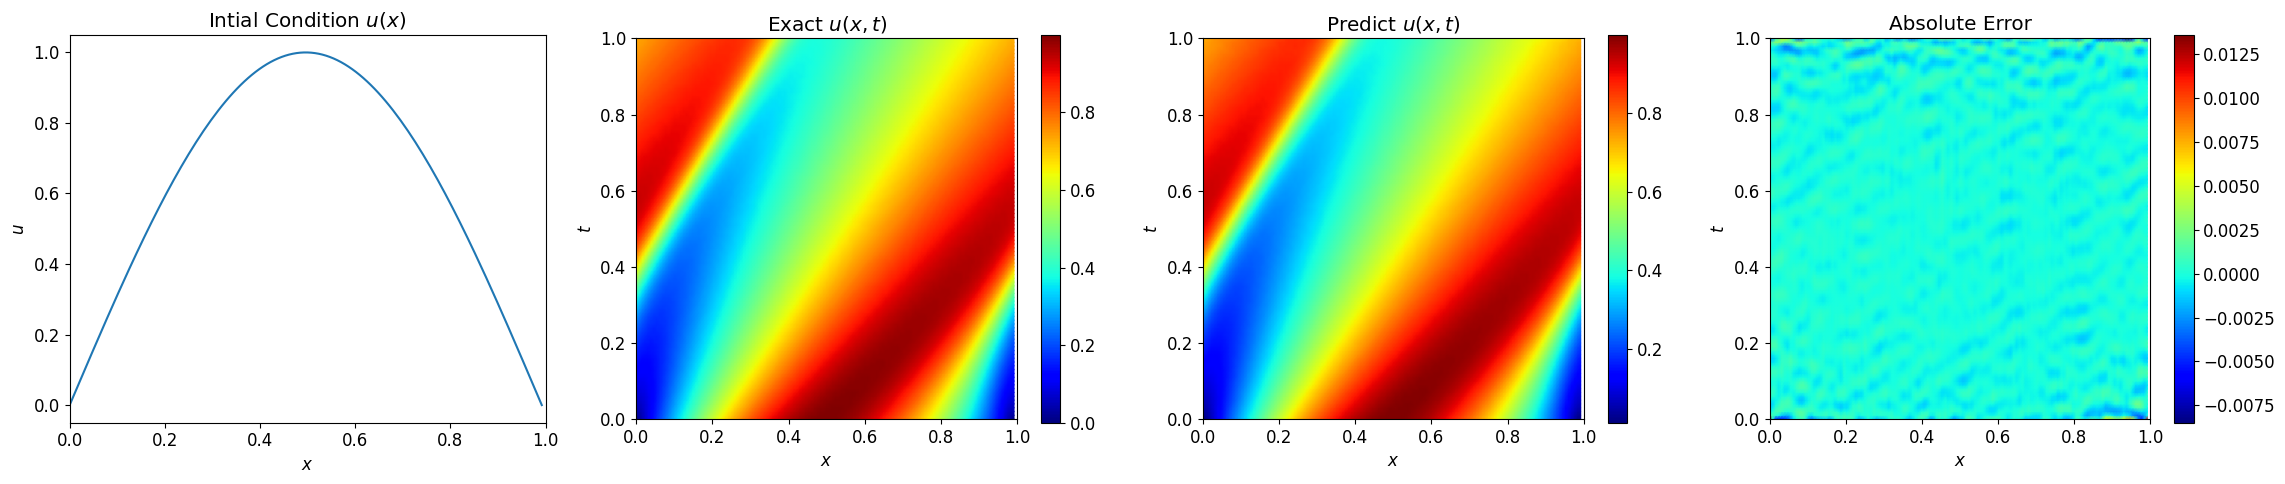

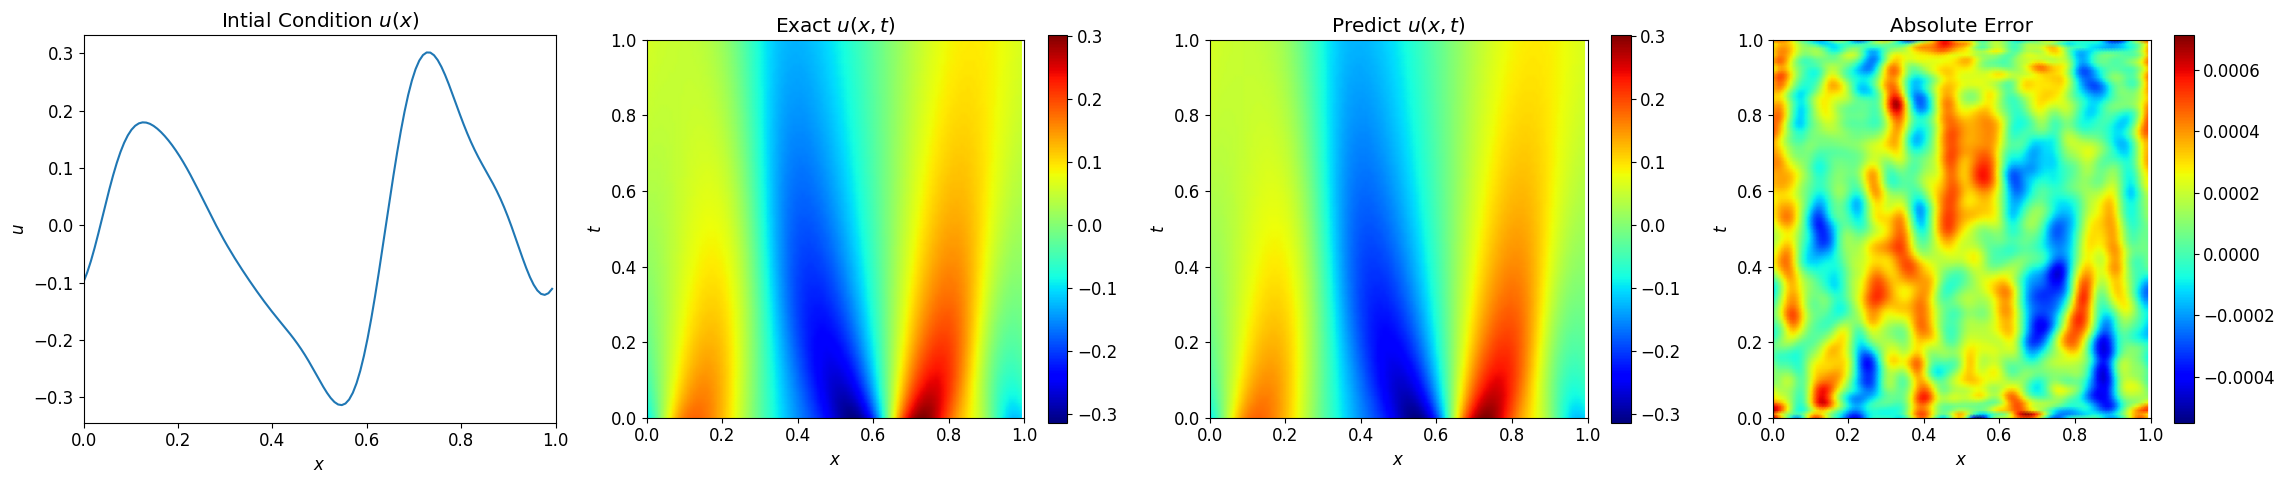

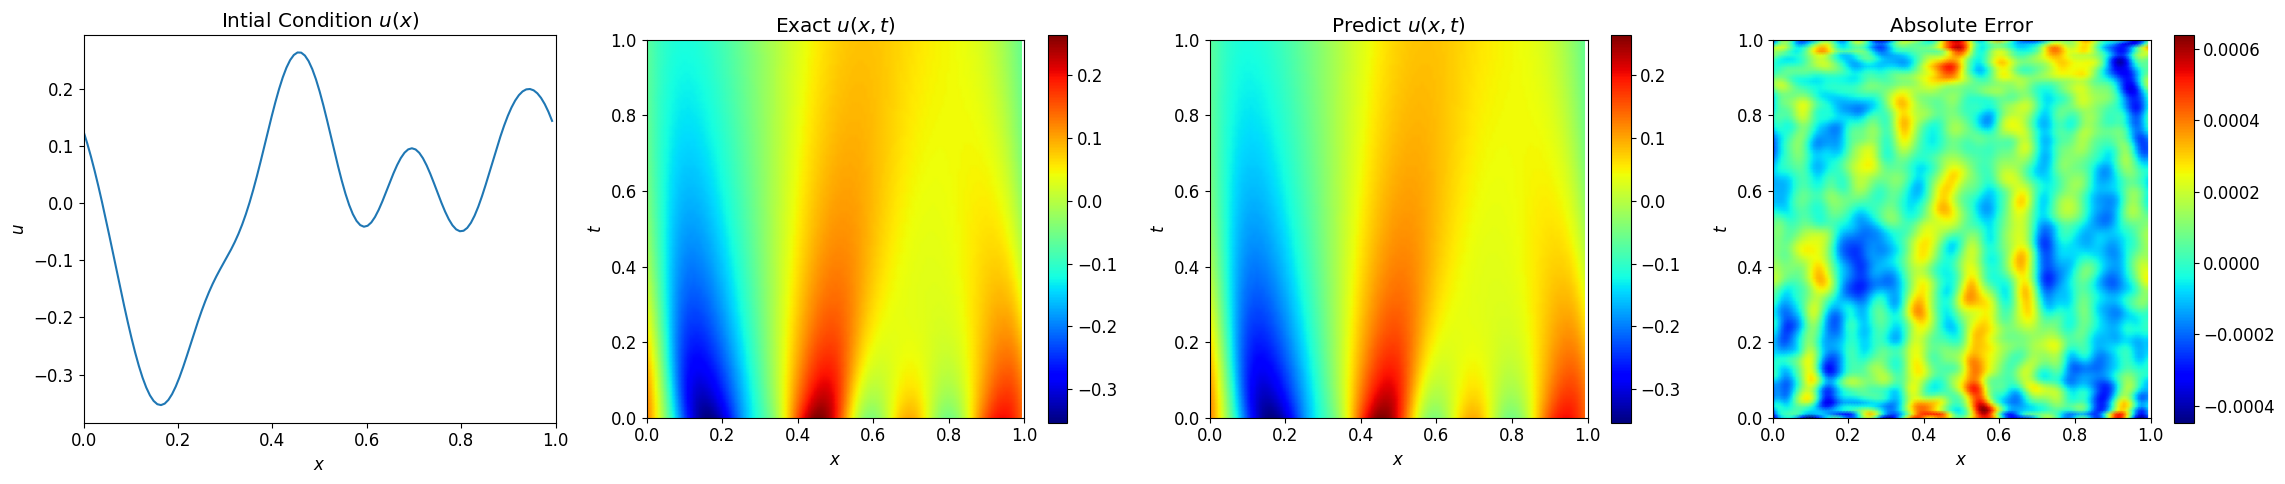

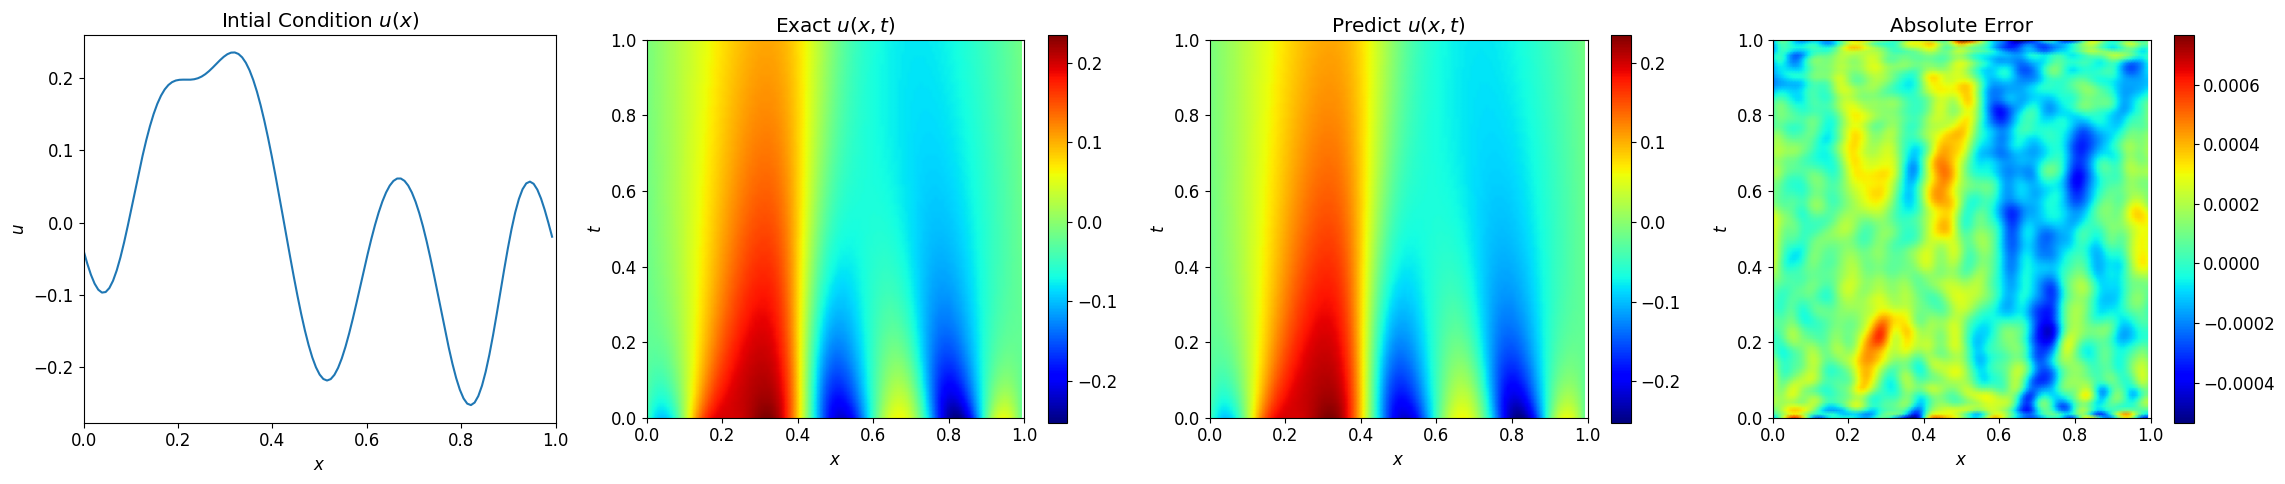

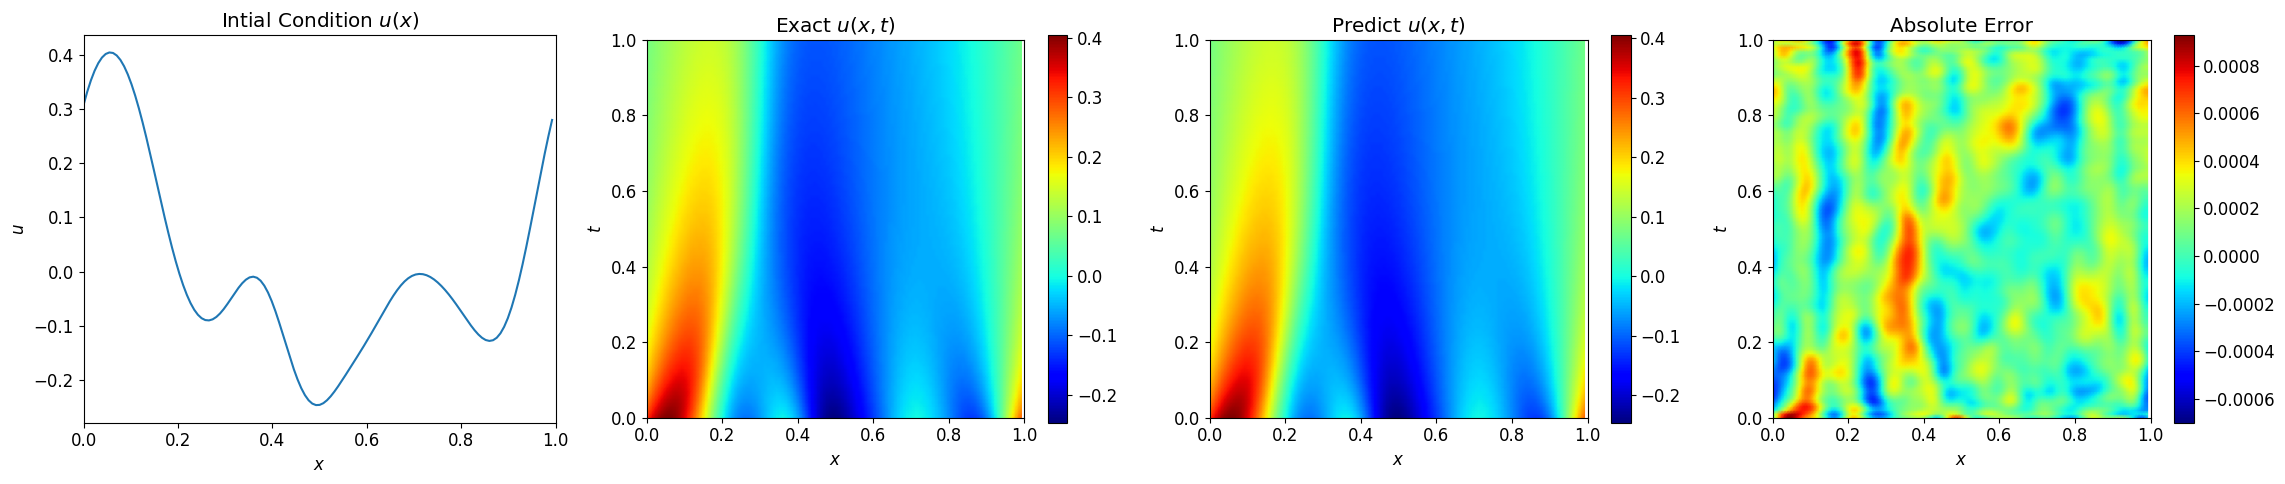

In [44]:
%matplotlib inline
figures_dir = 'Burgers1D/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers1D_{key}')
    plot_predictions(key, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


In [45]:
def generate_movie_1D(key, test_x, test_y, preds_y, plot_title='', movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg', remove_frames=True, font_size=None):
    frame_files = []
    os.makedirs(movie_dir, exist_ok=True)

    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    
    pred = preds_y[key]
    true = test_y[key]

    
    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]
    t = T[:,0]

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    a = test_x[key]
    Nt, Nx, _ = a.shape
    u0 = a[0,:,0]
    T = a[:,:,2]
    X = a[:,:,1]
    x = X[0]
    ax.plot(x, true[0], 'b-', label='Exact')
    ax.plot(x, pred[0], 'r--', label='PINO Prediction')
    ylim = plt.ylim()
    xlim = [0, 1]
#     plt.xlim(xlim)
#     plt.xlabel(f'$x$')
#     plt.ylabel(f'$u$')
#     plt.title(f'{plot_title} $t={t[0]:.2f}$')
#     plt.legend(loc='lower right')
    plt.tight_layout()
    
    
    
    for i in range(Nt):
        ax.clear()
        ax.plot(x, true[i], 'b-', label='Exact')
        ax.plot(x, pred[i], 'r--', label='PINO Prediction')
        plt.ylim(ylim)
        plt.xlim(xlim)
        plt.xlabel(f'$x$')
        plt.ylabel(f'$u$')
        plt.title(f'{plot_title} $t={t[i]:.2f}$')
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.canvas.draw()
#         plt.show()
        if movie_dir:
            frame_path = os.path.join(movie_dir,f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)
    
    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)
                
    if movie_dir and remove_frames:
        for frame in frame_files:
            try:
                os.remove(frame)
            except:
                pass


In [46]:
data_dir = 'data/Burgers1D'
data_filename = 'data.npz'
data_path = os.path.join(data_dir, data_filename)
test_x, test_y, preds_y = load_data(data_path)
movie_dir = f'Burgers1D/movie/'
os.makedirs(movie_dir, exist_ok=True)



C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\2171251395.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\2171251395.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


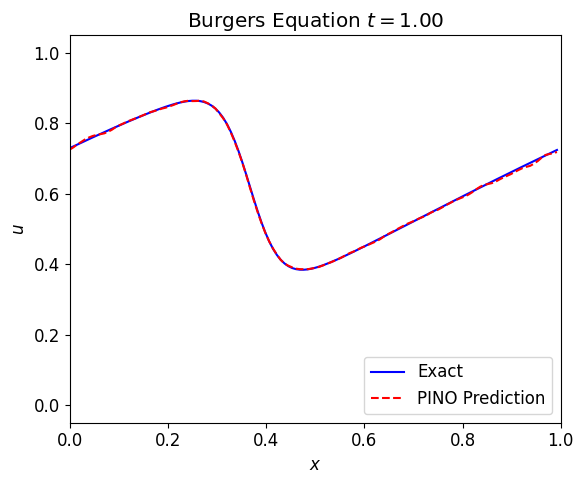

In [47]:
%matplotlib inline
key = 0
movie_name = f'Burgers1D_{key}.gif'
frame_basename = f'Burgers1D_{key}_frame'
frame_ext = 'jpg'
plot_title = "Burgers Equation"
font_size = 12
remove_frames = True

generate_movie_1D(key, test_x, test_y, preds_y, plot_title=plot_title, movie_dir=movie_dir, movie_name=movie_name, frame_basename=frame_basename, frame_ext=frame_ext, remove_frames=remove_frames, font_size=font_size)


C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\2171251395.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\2171251395.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


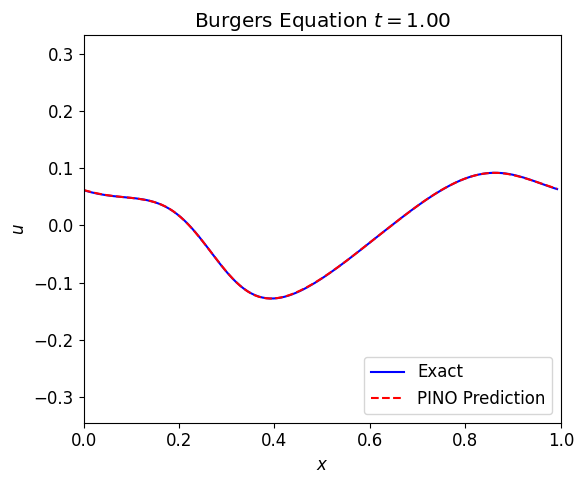

In [48]:
%matplotlib inline
key = 1
movie_name = f'Burgers1D_{key}.gif'
frame_basename = f'Burgers1D_{key}_frame'
frame_ext = 'jpg'
plot_title = "Burgers Equation"
font_size = 12
remove_frames = True

generate_movie_1D(key, test_x, test_y, preds_y, plot_title=plot_title, movie_dir=movie_dir, movie_name=movie_name, frame_basename=frame_basename, frame_ext=frame_ext, remove_frames=remove_frames, font_size=font_size)


C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\2171251395.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\Sarry\AppData\Local\Temp\ipykernel_33092\2171251395.py:67: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


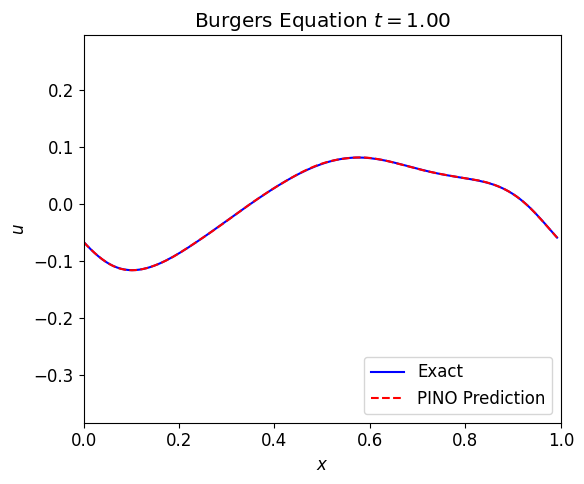

In [49]:
%matplotlib inline
key = 2
movie_name = f'Burgers1D_{key}.gif'
frame_basename = f'Burgers1D_{key}_frame'
frame_ext = 'jpg'
plot_title = "Burgers Equation"
font_size = 12
remove_frames = True

generate_movie_1D(key, test_x, test_y, preds_y, plot_title=plot_title, movie_dir=movie_dir, movie_name=movie_name, frame_basename=frame_basename, frame_ext=frame_ext, remove_frames=remove_frames, font_size=font_size)


In [50]:
%matplotlib notebook
pred = preds_y[key]
true = test_y[key]
a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.xlim(xlim)
plt.xlabel(f'$x$')
plt.ylabel(f'$u$')
# plt.title(f'Burgers Equation $t={t[0]:.2f}$')
plt.legend(loc='lower right')
plt.tight_layout()
for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    # plt.title(f'Burgers Equation $t={t[i]:.2f}$')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>

In [51]:
key = 0
a = test_x[key]

Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
t = T[:,0]
t

array([0.        , 0.01      , 0.02      , 0.03      , 0.04      ,
       0.05      , 0.06      , 0.07      , 0.08      , 0.09      ,
       0.1       , 0.11      , 0.12      , 0.13      , 0.14      ,
       0.15000001, 0.16      , 0.17      , 0.18000001, 0.19      ,
       0.2       , 0.20999999, 0.22      , 0.23      , 0.23999999,
       0.25      , 0.25999999, 0.27000001, 0.28      , 0.28999999,
       0.30000001, 0.31      , 0.31999999, 0.33000001, 0.34      ,
       0.34999999, 0.36000001, 0.37      , 0.38      , 0.38999999,
       0.40000001, 0.41      , 0.41999999, 0.43000001, 0.44      ,
       0.44999999, 0.46000001, 0.47      , 0.47999999, 0.49000001,
       0.5       , 0.50999999, 0.51999998, 0.52999997, 0.54000002,
       0.55000001, 0.56      , 0.56999999, 0.57999998, 0.58999997,
       0.60000002, 0.61000001, 0.62      , 0.63      , 0.63999999,
       0.64999998, 0.66000003, 0.67000002, 0.68000001, 0.69      ,
       0.69999999, 0.70999998, 0.72000003, 0.73000002, 0.74000

In [52]:
%matplotlib notebook
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
a = test_x[key]
Nt, Nx, _ = a.shape
u0 = a[0,:,0]
T = a[:,:,2]
X = a[:,:,1]
x = X[0]
t = T[:,0]
ax.plot(x, true[0], 'b-', label='Exact')
ax.plot(x, pred[0], 'r--', label='PINO Prediction')
ylim = plt.ylim()
xlim = [0, 1]
plt.tight_layout()



for i in range(Nt):
    ax.clear()
    ax.plot(x, true[i], 'b-', label='Exact')
    ax.plot(x, pred[i], 'r--', label='PINO Prediction')
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.xlabel(f'$x$')
    plt.ylabel(f'$u$')
    plt.title(f'Burgers Equation $t={t[i]:.2f}$')
    plt.legend(loc='lower right')
    plt.tight_layout()
    fig.canvas.draw()


<IPython.core.display.Javascript object>

In [2]:
def plot_loss_line(l):
    # 输入一个loss矩阵，计算误差,l为一个二维矩阵
    y=np.array(l)
    y=y[:,1]
    x=np.linspace(1,10+len(y),len(y))
    plt.plot(x,np.log(y))
    plt.xlabel(f'$iteration$')
    plt.ylabel(f'$loss(log)$')
    plt.title(f'Burgers Equation Loss')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [3]:
%matplotlib inline
# loss=loss_1+loss_2
# loss=np.array(loss)
# x=np.linspace(1,len(loss)+1,len(loss))
# y=np.log(loss[:,1])
# plt.plot(x,y)
plot_loss_line(loss_1)
plot_loss_line(loss_2)

NameError: name 'loss_1' is not defined